In [15]:
img_path = 'C:/TakeMeHome/IM/web_app/flaskapp/static/cache_images/some_image.jpg'

In [17]:
ip = Image_Preprocessing()
img = ip.face_preprocessing(img_path)

In [27]:
img[0].shape[0]

227

In [32]:
import numpy as np 

In [ ]:
np.hstack

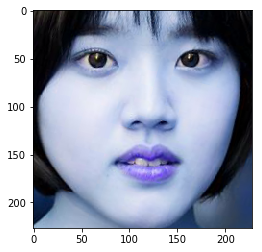

In [47]:
img_list = [img_.shape[0]+img_.shape[1] for i,img_ in enumerate(img)]
plt.imshow(img[np.argmax(np.array(img_list))])

77

77

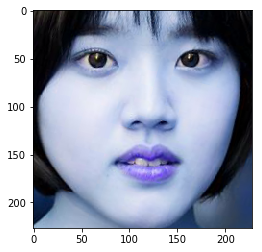

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img[0])

In [13]:
fe = Face_Embedding()


emb1 = fe.get_face_embedding(img_path, True)


In [1]:
import face_recognition
import cv2
import os
import numpy as np
import pandas as pd

class Image_Preprocessing:
    def __init__(self):
        pass
    def face_preprocessing(self, image_path, path_bool = True):
        return self.crop_rotate(image_path, path_bool)
        
    # 얼굴 영역별로 각 사진을 회전시키고
    # 회전된 얼굴만 잘라냄(랜드마크와 얼굴검출영역 최대값으로 얼굴이 최대한 온전히 나오게)
    def crop_rotate(self, img_path, path_bool):
        if path_bool:
            image = cv2.imread(img_path)
        else :
            image = img_path
        face_landmarks = face_recognition.face_landmarks(image)

        image_list = []
        # 각 얼굴들 검출해서 회전시킬 중심점들을 찾아서 (몇번째 얼굴, 회전 중심)의 dict형태로 추가
        for landmarks in face_landmarks:
            left_eye_center = np.array(landmarks['left_eye']).mean(axis=0)
            right_eye_center = np.array(landmarks['right_eye']).mean(axis=0)
            lec_x = int(left_eye_center[0])
            lec_y = int(left_eye_center[1])
            rec_x = int(right_eye_center[0])
            rec_y = int(right_eye_center[1])
            # 눈의 중앙 좌표와 각을 구함
            angle = np.degrees(np.arctan2((lec_y - rec_y), (lec_x - rec_x))) - 180
            # print("left_eye_center : {} right_eye_center : {}".format((lec_x, lec_y), (rec_x, rec_y)))
            # print("angle : {}".format(angle))
            # 회전 중심 점
            center_rotate = [int((lec_x + rec_x) / 2), int((lec_y + rec_y) / 2)]
            M = cv2.getRotationMatrix2D((center_rotate[0], center_rotate[1]), angle, 1)
            image_list.append(self.crop_image(image, center_rotate, M))

        return image_list

    # 두 점 사이의 거리
    def distacne_two_point(self, list_point1, list_point2):
        dx = list_point1[0] - list_point2[0]
        dy = list_point1[1] - list_point2[1]
        # 굳이 소수점까지 볼 필요는 없음
        return int((dx ** 2 + dy ** 2) ** 0.5)

    # 각 이미지로 부터 회전 중심값과 회전 설정 값을 받아
    # 이미지를 회전시키고 그 중 보내진 이미지의 얼굴영역과 가장 가까운 얼굴을 도려냄
    def crop_image(self, image, center_rotate, M):
        rotate_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        face_landmarks = face_recognition.face_landmarks(rotate_image)
        distance_list = []

        for landmark in face_landmarks:
            left_eye_center = np.array(landmark['left_eye']).mean(axis=0)
            right_eye_center = np.array(landmark['right_eye']).mean(axis=0)
            eye_center = ((left_eye_center + right_eye_center) / 2).astype('uint16')
            # 회전된 이미지의 축은 이전 함수에서 해당하는 얼굴의 중심점이란걸 알 수 있다
            # 이 점과 그리고 현재 회전된 이미지에서의 landmark의 중심점 사이의 거리가 가장 짧은 얼굴이
            # 해당하는 얼굴이니 이 얼굴을 도려내야함
            # print("center_rotate : {} , eye_center : {}".format(center_rotate, eye_center))
            distance_list.append(self.distacne_two_point(eye_center, center_rotate))

        # distance가 가장 짧은 index를 가지고 옴
        for i, d in enumerate(distance_list):
            if d == min(distance_list):
                crop_image_index = i
        # print("distance_list : {}".format(distance_list))
        # print("crop_image_index : {}".format(crop_image_index))
        # print("len(face_landmarks) : {}".format(len(face_landmarks)))
        current_face_mark = face_landmarks[crop_image_index]

        landmarks_list = []
        for k in current_face_mark.keys():
            landmarks_list.extend(current_face_mark[k])
        landmarks_array = np.array(landmarks_list)
        rect_list = []
        # 얼굴 rect를 x,y좌표로 구분해놓고
        for array in np.split(np.array(face_recognition.face_locations(rotate_image)[crop_image_index]), 2):
            rect_list.append(array)
        # landmkar와 rect에 대한 x,y,좌표를 np.array로 만들어서 최소값 최대값을 쉽게 뽑도록 함
        for i in range(len(rect_list)):
            temp = rect_list[i][0]
            rect_list[i][0] = rect_list[i][1]
            rect_list[i][1] = temp
            landmarks_array = np.vstack((landmarks_array, rect_list[i].reshape((-1, 2))))
        min_xy = landmarks_array.min(axis=0)
        max_xy = landmarks_array.max(axis=0)

        return rotate_image[min_xy[1]:max_xy[1], min_xy[0]:max_xy[0]]


class Face_Embedding:
    # 생성자에서 db 만듬
    def __init__(self):
        self.img_preprocessing = Image_Preprocessing()
        self.csv_path = './flaskapp/static/database/embedding_db.csv'
        self.dbimg_path = './flaskapp/static/images'
        self.embedding_csv_db = None
    
    def create_facedict(self):
        self.face_database = {}
        self.setup_database(self.dbimg_path)

    # image가 얼굴을 갖고 있는지 check
    def check_img(self, image_path, path_bool):
        if path_bool:
            img_ = cv2.imread(image_path)
        else:
            img_ = image_path
        # 얼굴이 없을 때 
        if len(face_recognition.face_locations(img_)) == 0:
            return 0
        else:
            return 1

    # opencv의 경우는 rgb가아닌 bgr의 color이기 때문 plt로 출력할거 아니면 안바꿔도 됨
    def convert_rgb(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # iamge path로 image를 각 얼굴에대해 회전하고 랜드마크를 포함하게 잘라내서 embedding 값 받음
    def get_face_embedding(self, image_path, path_bool = True):
        # 얼굴 없으면 0,0
        # print(image_path)
        if self.check_img(image_path, path_bool) == 0:
            print('얼굴을 찾을 수 없습니다')
            return 0
        else:
            face_encoding_list = []
            images = self.img_preprocessing.face_preprocessing(image_path, path_bool)
            for img in images:
                img_size = [(0, img.shape[1], img.shape[0], 0)]
                face_encoding = face_recognition.face_encodings(img, img_size)
                # list 형태로 return 하기 때문에
                face_encoding_list.append(face_encoding[0])
            #[ numpy.array([ 0,. 35 ,, ....])] 형태로 return 
            return face_encoding_list

    # setup_db
    def setup_database(self, img_path):
        # setup 성공한 이미지 / 전체 이미지
        total_image = len(os.listdir(img_path))
        count = 0
        not_face = []

        # ./test_images/test1/ 내의 모든 파일
        for p in os.listdir(img_path):
            # 파일 이름을 key로
            identity = str.split(p, '.')[0]
            print("file {} embedding...".format(p))
            # 해당 이미지 파일 경로를 _img로 해놓고
            img_ = os.path.join(img_path, p)
            # 해당 이미지에대한 embedding값 구해서 encodings에 넣어줌
            encodings = self.get_face_embedding(img_)
            # 실패한 파일들 볼 수 있도록 append
            if encodings == 0:
                not_face.append(p)
                continue
            elif len(encodings) == 1:
                self.face_database[identity] = encodings
            # 사진에 여러 얼굴 검출되면
            # [array1, array2] 처럼 하나의key에 각 얼굴들의 embedding 값을 넣어 줌
            else:
                self.face_database[identity] = [e for e in encodings]
            # encodings(embedding 값)은 128차원의 특징 값
            count += 1
            print("{} / {}".format(count, total_image))
        print("얼굴을 못 읽는 이미지 : {}".format(not_face))


    # 들어온 이미지와 DB를 비교
    # def compare_db(self, img_path, path_bool = True):
    #     bool_list = []
    #     for k in self.face_database.keys():
    #         _, compare_check = self.compare_img(img_path, self.face_database[k],path_bool)
    #         if path_bool:
    #             if compare_check:
    #                 print('{}는 {}와 일치합니다'.format(os.path.split(img_path)[-1], k))
    #             else:
    #                 print('{}는 {}와 불 일치합니다'.format(os.path.split(img_path)[-1], k))
    #         else:
    #             if compare_check:
    #                 print('올린 이미지는 {}와 일치합니다'.format(k))
    #             else:
    #                 print('올린 이미지는는 {}와 불 일치합니다'.format(k))

    #         bool_list.extend(compare_check)
    #     return bool_list

    
    #가장 유사한 이미지 return
    # def similar_compare_db(self, img_path, path_bool = True):
    #     diff_list = []
    #     db_diff = {}
    #     for i, k in enumerate(self.face_database.keys()):
    #         db_diff[i] = k
    #         distance_diff, compare_check = self.compare_img(img_path, self.face_database[k],path_bool)

    #         diff_list.extend(distance_diff)
    #     min_diff = np.array(diff_list).argmin()
    #     print('{}가 {}만큼 가까워서 제일 유사한 얼굴'.format(db_diff[min_diff], diff_list[0]))
    #     return db_diff[min_diff]

    # 특정 경로 폴더의 이미지들 embedding 값들을 뽑아서 csv로 저장
    def embedding_to_csv(self):
        embedding_list = []
        for k in self.face_database:
            embedding_list.append(self.face_database[k][0])
        embedding_df = pd.DataFrame(embedding_list, index = list(self.face_database.keys()))
        embedding_df.to_csv(self.csv_path, index=True, header=True)

    # csv db를 읽음
    def load_csv_db(self):
        load_embedding_csv = pd.read_csv(self.csv_path)
        file_name = list(load_embedding_csv.iloc[:, 0])
        load_embedding_csv.index = file_name
        # index를 파일 이름으로 해주기 위함 
        return load_embedding_csv.drop(load_embedding_csv.columns[0], 1)

        # 이미지가 같은지 embedding된 값으로 비교



    # tolerance 이 더 낮으면 엄격함, 0.6을 추천함
    def compare_img(self, img_path, encoding_check_img, path_bool=True, tolerance=0.4):
        if path_bool:
            encoding_origin_img = self.get_face_embedding(img_path, path_bool)
        else:
            encoding_origin_img = img_path
        
        distance_diff = []
        if encoding_check_img == 0:
            return [1], [False]
        if len(encoding_check_img) > 1:
            face_diff = []
            dist_diff = []
            # 여기서 encdoing_check_img는 이중list의 형태
            # [[np.array], [np.array]]
            for e in encoding_check_img:
                # 해당 embedding 값들과 비교하고자하는 original image 얼굴의 embedding값 비교
                # face_recognition.face_distance는 내부적으로
                # 두 벡터간의 차를 구하고 그 차에대해 벡터의 길이를 구함
                # 즉 길이가 짧을 수록(값이 작을 수록) 두 얼굴은 일치
                diff = face_recognition.face_distance(encoding_origin_img, e)
                # 벡터간 거리
                dist_diff.append(diff)
                print(diff)
                face_diff.append(list(diff <= tolerance))
            distance_diff.extend(min(dist_diff))
            print(face_diff)
            return distance_diff, [any(list(face_diff))]
        # 한 사진에 한 얼굴만 검출되면 np.array 타입으로 반환하기때문에 바로 비교
        # 첫번째 인자의 embedding값은 list형태로, 2번째 인자는 numpy 형태로 들어가줘야 함
        face_diff = face_recognition.face_distance(encoding_origin_img, encoding_check_img[0])

        distance_diff.append(face_diff)
        print("distance_diff : {} \n list(face_diff <= tolearnace) : {}".format(distance_diff, list(face_diff <= tolerance)))
        # 두 이미지가 얼마나 거리가 먼지 [numpy.array([])], 일치한지 아닌지 [False] 형태로 return
        return distance_diff, list(face_diff <= tolerance)
        # compare_faces는 내부적으로
        # 128차원의 embedding된 값의 차로 얼굴간의 거리를 구한뒤
        # np.linalg.norm를 통해 128차원의 벡터의 길이를 구함
        # 이길이가 tolerance보다 작을때 두 이미지는 같은 이미지로 간주
        # tolearnace의 값을 높이면 비교연산이 좀더 관대해지게됨


    # csv파일로부터 upload되는 이미지와 embeddig 값 비교하기
    def compare_csvdb(self, img_path, path_bool=True):
        bool_list = []

        for i in range(len(self.embedding_csv_db.index)):
            _, compare_check = self.compare_img(img_path, [self.embedding_csv_db.iloc[i].values], path_bool)
            print(compare_check)
            if path_bool:
                if compare_check[0]:
                    print('{}는 {}와 일치합니다'.format(os.path.split(img_path)[-1], self.embedding_csv_db.index[i]))
                else:
                    print('{}는 {}와 불 일치합니다'.format(os.path.split(img_path)[-1], self.embedding_csv_db.index[i]))
            else:
                if compare_check[0]:
                    print('올린 이미지는 {}와 일치합니다'.format(self.embedding_csv_db.index[i]))
                else:
                    print('올린 이미지는는 {}와 불 일치합니다'.format(self.embedding_csv_db.index[i]))

            print("shape : {}".format((self.embedding_csv_db.iloc[i].values).shape))
            bool_list.extend(compare_check)
        print("bool_list : {}".format(bool_list))
        # 각 db 인스턴스 목록으로 부터 [True, False, .... ] 처럼 list형태로 일치하는지 안하는지를 return
        return bool_list
   
    def similar_compare_csvdb(self, img_path, path_bool = True):

        diff_list = []
        db_diff = {}
        for i, k in enumerate(self.embedding_csv_db.index):
            db_diff[i] = k
            distance_diff, compare_check = self.compare_img(img_path, [self.embedding_csv_db.iloc[i].values], path_bool, 0.4)
            diff_list.extend(distance_diff)

        min_diff = np.array(diff_list).argmin()
        print('{}가 {}만큼 가까워서 제일 유사한 얼굴'.format(db_diff[min_diff], diff_list[0]))
        print("db_diff[min_diff] : {}".format(db_diff[min_diff]))
        # db csv에 저장된 해당 인스턴스의 index값 즉 파일이름, diff distance 리턴 
        return db_diff[min_diff], diff_list[min_diff]


# test1 = Face_Embedding()
# test1.embedding_to_csv()

# image1 = cv2.imread('C:/TakeMeHome/IM/web_app/flaskapp/static/images/kim2.jpg')
# emb1 = test1.get_face_embedding(image1, False)
# test1.compare_csvdb(emb1, False)
# test1.similar_compare_csvdb(emb1, False)


# db_image_path = 'C:/TakeMeHome/IM/opencv_project/TMH_PJ/test_images/test1'
# test1 = Face_Embedding()
# test_img = cv2.imread('C:/TakeMeHome/IM/opencv_project/TMH_PJ/test_images/kim1.jpg')
# test1.setup_database(db_image_path)
# print(test1.face_database)

# test1 = Face_Embedding()
# image1 = cv2.imread('C:/TakeMeHome/IM/web_app/flaskapp/static/images/kim2.jpg')
# #image2 = cv2.imread('C:/TakeMeHome/IM/web_app/flaskapp/static/images/kim4.jpg')
# image2 = cv2.imread('C:/TakeMeHome/IM/web_app/flaskapp/static/images/test1.jpg')
# emb1 = test1.get_face_embedding(image1, False)
# emb2 = test1.get_face_embedding(image2, False)
# print("emb1 : {}".format(emb1))
# print("emb2 : {}".format(emb2))
# diff_dis, matching_bool = test1.compare_img(emb1, emb2, False)
# print(test1.similar_compare_db(emb1, False))

# print(diff_dis[0])
# print(matching_bool[0])
# print("matching scroe : " + str(diff_dis[0]) + "\n" + "matching : " +  str(matching_bool[0]))

# print(np.linalg.norm(emb1[0] - emb2[0][0], axis=1))
# test1.compare_img(emb1[0][0], emb2[0], False)


# db_image_path = 'C:/TakeMeHome/IM/opencv_project/TMH_PJ/test_images/test1'
# test1 = Face_Embedding()
# test_img = cv2.imread('C:/TakeMeHome/IM/opencv_project/TMH_PJ/test_images/kim1.jpg')
# test1.setup_database(db_image_path)
# test1.similar_compare_db(test_img, path_bool=False)


# test_db = test1.setup_database(db_image_path)
# print(test_db.keys())
# print(test1.compare_img('./test_images/kim1.jpg', test_db['kim2']))
# #print(test1.compare_img('./test_images/kim1.jpg', test_db['test1']))
# print(test1.compare_db('./test_images/kim1.jpg'))
# print(test1.similar_compare_db('./test_images/kim1.jpg'))

# 이 파일을 직접실행할 경우
#if __name__ == '__main__':
#    db_image_path = './test_images/test1/'
#    test1 = Face_Embedding()
#    test1.setup_database(db_image_path)
#    print("*" * 100)
#    print(test1.face_database.keys())
#    print("*" * 100)
#    print(test1.compare_db('./test_images/kim1.jpg'))
#    print("*" * 100)
#    print(test1.similar_compare_db('./test_images/kim1.jpg'))




In [11]:
emb1

[array([-0.08692625,  0.02924975,  0.07754976, -0.08627661, -0.11096372,
        -0.03044385, -0.07579088, -0.13209528,  0.08670033, -0.17307693,
         0.14726442, -0.10828309, -0.22045076, -0.06527188, -0.02348135,
         0.17653856, -0.06673297, -0.15913871, -0.05329708, -0.01344125,
         0.05718642,  0.02489341,  0.01000817,  0.03951246, -0.10527047,
        -0.34256348, -0.15429534, -0.04060411, -0.12912938, -0.02003091,
        -0.0440723 ,  0.06676395, -0.20860949, -0.02789713,  0.03487179,
         0.08377644,  0.01297424, -0.05793558,  0.10687021, -0.01774493,
        -0.24770944,  0.06597631,  0.09831659,  0.23491289,  0.1697838 ,
        -0.0011609 , -0.00275739, -0.11362822,  0.09229432, -0.103192  ,
         0.03863025,  0.13170785,  0.03639397,  0.03584608,  0.03539605,
        -0.06662913,  0.08005464,  0.12362407, -0.10907412,  0.02578524,
         0.13059986, -0.10654759, -0.05723612, -0.1069166 ,  0.2321004 ,
         0.06104449, -0.12466235, -0.2346983 ,  0.0

In [12]:
len(emb1)

2